In [1]:
import sys
sys.path.append("..")
import torch
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]
torch.manual_seed(0)

from engression import engression
from engression.data.simulator import preanm_simulator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simulate data

In [4]:
x, y = preanm_simulator("square", n=10000, x_lower=0, x_upper=2, noise_std=1, train=True, device=device)
x_eval, y_eval_med, y_eval_mean = preanm_simulator("square", n=1000, x_lower=0, x_upper=4, noise_std=1, train=False, device=device)


# Engression

In [5]:

# Fit an engression model
engressor = engression(x, y, lr=0.005, num_epochs=500, batch_size=1000, device=device)

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Training based on mini-batch gradient descent with a batch size of 1000.
[Epoch 1 (0%), batch 9] energy-loss: 0.5381,  E(|Y-Yhat|): 0.9274,  E(|Yhat-Yhat'|): 0.7786
[Epoch 100 (20%), batch 9] energy-loss: 0.4117,  E(|Y-Yhat|): 0.8158,  E(|Yhat-Yhat'|): 0.8083
[Epoch 200 (40%), batch 9] energy-loss: 0.4112,  E(|Y-Yhat|): 0.8390,  E(|Yhat-Yhat'|): 0.8556
[Epoch 300 (60%), batch 9] energy-loss: 0.4106,  E(|Y-Yhat|): 0.8083,  E(|Yhat-Yhat'|): 0.7954
[Epoch 400 (80%), batch 9] energy-loss: 0.4194,  E(|Y-Yhat|): 0.8172,  E(|Yhat-Yhat'|): 0.7957
[Epoch 500 (100%), batch 9] energy-loss: 0.4190,  E(|Y-Yhat|): 0.8222,  E(|Yhat-Yhat'|): 0.8065

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.6222,  E(|Y-Yhat|): 1.2420,  E(|Yhat-Yhat'|): 1.2397

Predictio

In [6]:
# Summarize model information
engressor.summary()

Engression model with
	 number of layers: 2
	 hidden dimensions: 100
	 noise dimensions: 100
	 residual blocks: False
	 number of epochs: 500
	 batch size: 1000
	 learning rate: 0.005
	 standardization: True
	 training mode: False
	 device: cpu

Training loss (original scale):
	 energy-loss: 0.62, 
	E(|Y-Yhat|): 1.24, 
	E(|Yhat-Yhat'|): 1.24


In [7]:
# Evaluation
print("L2 loss:", engressor.eval_loss(x_eval, y_eval_mean, loss_type="l2"))
print("correlation between predicted and true means:", engressor.eval_loss(x_eval, y_eval_mean, loss_type="cor"))


L2 loss: 0.059014350175857544
correlation between predicted and true means: 0.9957661628723145


In [8]:
# Predictions
y_pred = engressor.predict(x_eval, target="mean", sample_size=1000)

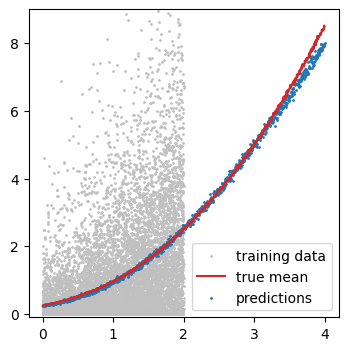

In [9]:

plt.scatter(x.cpu(), y.cpu(), label="training data", s=1, color="silver")
plt.plot(x_eval.cpu(), y_eval_mean.cpu(), label="true mean", color="C3")
plt.scatter(x_eval.cpu(), y_pred.cpu(), label="predictions", s=1)
plt.ylim(-0.1, 9)
plt.legend(); plt.show()

# Baseline: $L_2$ regression

In [10]:
from engression.models import Net

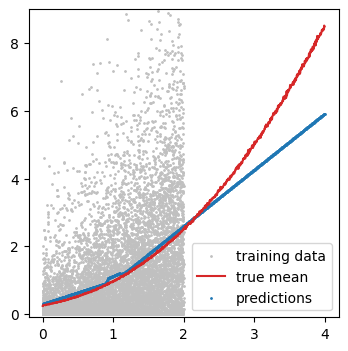

In [11]:
# Build a model with the same architecture
model = Net(num_layer=2, hidden_dim=100) # NN with the same architecture
opt = torch.optim.Adam(model.parameters(), lr=0.005) # same optimizer

# L2 regression training
model.train()
for i in range(500):
    model.zero_grad()
    y_pred = model(x)
    loss = (y_pred - y).pow(2).mean()
    loss.backward()
    opt.step()

# Evaluation
model.eval()
y_pred = model(x_eval).detach()
plt.scatter(x.cpu(), y.cpu(), label="training data", s=1, color="silver")
plt.plot(x_eval.cpu(), y_eval_mean.cpu(), label="true mean", color="C3")
plt.scatter(x_eval.cpu(), y_pred.cpu(), label="predictions", s=1)
plt.ylim(-0.1, 9)
plt.legend(); plt.show()